RNN LSTM for text classification
=============
<span style="color: lightsteelblue;">Deep Learning</span>

The goal of this notebook is to train recurrent neural network with LSTM cell for the purpose of text classification.

## 1. Data preparation

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import collections
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from pathlib import Path
import os
import time

# custom libraries
from nlp.preparer import Corpus
from nlp.iterator import BatchIterator
from nlp.conveyor import Conveyor

# View
from IPython.display import Markdown, display

### Loading corpora

In [2]:
corpora_paths = ['./articles/good.articles', './articles/bad.articles'] 
corpora = []
lengths = []

for path in corpora_paths:
  corpus = Corpus(path, 321)
  corpora.append(corpus)
  length = [len(article) for article in corpus.articles]
  lengths.append(length)

  print(f"Corpus label: {corpus.label}, ",
        f"length: {len(corpus.articles)} articles, ",
        f"av length: {round(corpus.average_length())} words, ",
        f"max length: {max(length)} words.")
  print(f"Corpus raw article: {corpus.raw[0][:200]}")
  print(f"Corpus data (words): {corpus.articles[0][:20]}\n")

Corpus label: good,  length: 9196 articles,  av length: 232 words,  max length: 447 words.
Corpus raw article: 3 февраля в большинстве европейских стран закрылось зимнее трансферное окно — период, когда клубы могут заявлять новых футболистов, купленных у других команд. Ценники меняются чуть ли не ежемесячно. Н
Corpus data (words): ['num', 'феврал', 'в', 'большинств', 'европейск', 'стран', 'закр', 'зимн', 'трансферн', 'окн', 'период', ',', 'когд', 'клуб', 'могут', 'заявля', 'нов', 'футболист', ',', 'куплен']

Corpus label: bad,  length: 7521 articles,  av length: 84 words,  max length: 392 words.
Corpus raw article: Неизвестный угрожает взорвать аэропорт Кишинева, если ему не дадут миллион. Неизвестный сообщил о бомбе в аэропорту Международного аэропорта Кишинева и требует миллион рублей, сообщили в пограничной п
Corpus data (words): ['неизвестн', 'угрожа', 'взорва', 'аэропорт', 'кишинев', ',', 'есл', 'ем', 'не', 'дадут', 'миллион', '.', 'неизвестн', 'сообщ', 'о', 'бомб', 'в', 'аэропорт

### Visualizing articles lengths

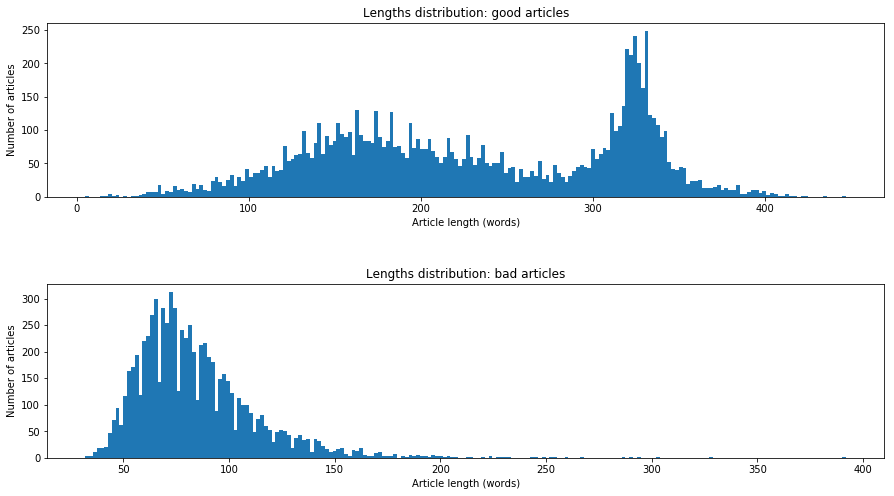

In [3]:
# visualization
plt.figure().set_size_inches(15, 8)

plt.subplot(211)
plt.xlabel('Article length (words)')
plt.ylabel('Number of articles')
plt.title(f'Lengths distribution: {corpora[0].label} articles')
plt.hist(lengths[0], 200)

plt.subplots_adjust(hspace=.5)

plt.subplot(212)
plt.xlabel('Article length (words)')
plt.ylabel('Number of articles')
plt.title(f'Lengths distribution: {corpora[1].label} articles')
plt.hist(lengths[1], 200)

plt.show()

### Building a dictionary

In [4]:
STORAGE_PATH = './storage/model' # to restore model's knowledge later
validation_size = 20 # articles per each class
vocabulary_size = 25000

def build_dictionary(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 

  return dictionary, reverse_dictionary, count

def build_dataset(words, dictionary, count):
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)

  count[0][1] = count[0][1] + unk_count

  return data

# flatten all words into a single bag
all_words = [word for corpus in corpora for words in corpus.articles for word in words]

dictionary_file_name = f"{STORAGE_PATH}.dictionary"
if Path(dictionary_file_name).is_file():
  dictionary_file_size = os.path.getsize(dictionary_file_name)
  print(f"Loading dictionary from stored file ({dictionary_file_size} bytes)...")
  with open(dictionary_file_name, 'rb') as fp:
    dictionary, reverse_dictionary, count = pickle.load(fp)
else:
  print('Building dictionary from the corpora...')
  dictionary, reverse_dictionary, count = build_dictionary(all_words)
  print('Saving dictionary on disk for further access...')
  with open(dictionary_file_name, 'wb') as fp:
    pickle.dump((dictionary, reverse_dictionary, count), fp)
  dictionary_file_size = os.path.getsize(dictionary_file_name)
  print(f"Done. It took {dictionary_file_size} bytes on the disk.")

good_data = [build_dataset(article, dictionary, count) for article in corpora[0].articles]
bad_data  = [build_dataset(article, dictionary, count) for article in corpora[1].articles]

# Splitting between train and validation datasets
good_train_data = good_data[:-validation_size]
good_validation_data = good_data[-validation_size:]
bad_train_data = bad_data[:-validation_size]
bad_validation_data = bad_data[-validation_size:]
validation_data = [item for ga, ba in zip(good_validation_data, bad_validation_data) for item in [ga, ba]]

print(f"Top popular words counts: {count[:15]}\n")
print(f"Example word: {dictionary['слон']} => {reverse_dictionary[dictionary['слон']]}\n")
print(f'Example data: {good_data[0][:20]}\n')
print(f'Validation sizes split train / validation: {len(good_train_data)} / {len(good_validation_data)}')
print(f'Validation dataset size: {len(validation_data)}')

Loading dictionary from stored file (1193403 bytes)...
Top popular words counts: [['UNK', 54382], (',', 191060), ('.', 167323), ('в', 121865), ('num', 70531), ('и', 59470), ('на', 47402), ('с', 26509), ('что', 22411), ('по', 21900), ('эт', 21548), ('не', 21271), ('из', 16381), ('год', 15883), ('он', 14053)]

Example word: 3144 => слон

Example data: [4, 385, 3, 606, 600, 50, 1918, 1257, 10523, 1302, 540, 1, 89, 359, 255, 2110, 49, 999, 1, 6766]

Validation sizes split train / validation: 9176 / 20
Validation dataset size: 40


Below is an **example** of two training batches spat out by `BatchIterator`:

In [6]:
batch_size = 64 # Number of articles fed into a model at once
num_unrollings = 10 # Number of recurrent steps

good = [1., 0.] # Representation of first class
bad  = [0., 1.] # Representation of second class

min_size = min(len(good_train_data), len(bad_train_data))
articles_pool = [(data, good) for data in good_train_data[:min_size]] + \
                [(data, bad)  for data in bad_train_data[:min_size]]

conveyors = [Conveyor(articles_pool, num_unrollings) for _ in range(batch_size)]

for _ in range(2):
  bundle = conveyors[0].next()
  print(bundle)
  print([reverse_dictionary[index] for index in bundle[0]])
conveyors[0].rewind()

([319, 2251, 3, 284, 488, 1184, 18940, 86, 3, 187], [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]], [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
['водител', 'такс', 'в', 'петербург', 'предлож', 'бесплатн', 'везт', 'пострада', 'в', 'метр']
([2, 3, 388, 284, 3716, 2642, 250, 86, 41, 316], [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0]], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
['.', 'в', 'санкт', 'петербург', 'таксист', 'перевоз', 'всех', 'пострада', 'при', 'теракт']


## 2. LSTM Model

In [8]:
num_nodes = 64 # Dimension of lstm cell
num_classes = 2 # Number of classes among which to predict
embedding_size = 128 # Dimension of a word vector
hidden_layer_size = 32

graph = tf.Graph()
with graph.as_default():

  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1), name='ix')
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1), name='im')
  ib = tf.Variable(tf.zeros([1, num_nodes]), name='ib')
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1), name='fx')
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1), name='fm')
  fb = tf.Variable(tf.zeros([1, num_nodes]), name='fb')
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1), name='ox')
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1), name='om')
  ob = tf.Variable(tf.zeros([1, num_nodes]), name='ob')
  # Memory cell: input, state and bias.
  cx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1), name='cx')
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1), name='cm')
  cb = tf.Variable(tf.zeros([1, num_nodes]), name='cb')
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, hidden_layer_size], -0.1, 0.1), name='w')
  b = tf.Variable(tf.zeros([hidden_layer_size]), name='b')
  hw = tf.Variable(tf.truncated_normal([hidden_layer_size, num_classes], -0.1, 0.1), name='hw')
  hb = tf.Variable(tf.zeros([num_classes]), name='hb')
  # Embeddings
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='embeddings')


  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    # Create an LSTM cell
    input_gate =  tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)

    return output_gate * tf.tanh(state), state

  # Input data.
  train_inputs   = tf.placeholder(tf.int32,   shape=[batch_size, num_unrollings])
  train_clearers = tf.placeholder(tf.float32, shape=[batch_size, num_unrollings])
  train_labels   = tf.placeholder(tf.float32, shape=[batch_size, num_unrollings, num_classes])

  # Unrolled LSTM loop.
  lstm_outputs = list()
  output = saved_output
  state  = saved_state
  embedded_batch = tf.nn.embedding_lookup(embeddings, train_inputs)
  lstm_inputs = tf.unstack(embedded_batch, axis=1) # list of ~ (batch_size, embedding_size)
  lstm_state_clearers = tf.unstack(train_clearers, axis=1) # list of ~ (batch_size, )

  for lstm_input_batch, state_clearers_batch in zip(lstm_inputs, lstm_state_clearers):
    reshaped_clearers = tf.reshape(state_clearers_batch, (batch_size, 1))
    output, state = lstm_cell(lstm_input_batch,
                              tf.multiply(reshaped_clearers, output),
                              tf.multiply(reshaped_clearers, state))

    lstm_outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    # here we use `tf.reshape(tf.stack())` instead of `tf.concat` to preserve 0th and 1th axes order
    joined_output = tf.reshape(tf.stack(lstm_outputs, axis=1), (-1, num_nodes))   
    joined_labels = tf.reshape(train_labels, (-1, num_classes))

    hidden_layer = tf.nn.xw_plus_b(joined_output, w, b)
    activation = tf.nn.tanh(hidden_layer)
    logits = tf.nn.xw_plus_b(activation, hw, hb)

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
      labels=joined_labels,
      logits=logits
    ))

  # Optimizer.
  global_step = tf.Variable(0, trainable=False, name='global_step')
  learning_rate = tf.train.exponential_decay(4.0, global_step, 5000, 0.8, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)

  # Storing knowledge to the disk
  saver = tf.train.Saver()

  # Sampling and validation evaluation
  # ==================================
  #
  # Sampling eval: one unrolling, no state clearers
  sample_input = tf.placeholder(tf.int32, shape=[1])
  sample_lstm_input = tf.nn.embedding_lookup(embeddings, sample_input)
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_lstm_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    hidden_sample_pred = tf.nn.xw_plus_b(sample_output, w, b)
    sample_activation = tf.nn.sigmoid(hidden_sample_pred)
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_activation, hw, hb))

  valid_labels = tf.placeholder(tf.float32, shape=[None, num_classes])
  valid_logits = tf.placeholder(tf.float32, shape=[None, num_classes])  
  validation_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels=valid_labels,
    logits=valid_logits
  ))
  
print('Graph was successfully built')

Graph was successfully built


## 3. Training

### Representation helpers

Before we dive into the very learning - let us define some useful helpers to better represent training process.

In [9]:
def print_md(string):
  display(Markdown(string))

def colored_p(text, prediction):
  g, r = [round(probability * 255) for probability in prediction]
  return f"<span style='color: rgb({r}, {g}, 0)'>{text}</span>"

def represent(words, predictions, tail=3):
  result = []
  temp = []
  changed_ago = 0
  for word, label, i in zip(words, predictions, range(len(words))):
    word_to_add = colored_p(word, label)

    if i == 0:
      temp.append(word_to_add)
      continue

    if label_to_color(predictions[i - 1]) == label_to_color(label):
      temp.append(word_to_add)
    else:
      if len(temp) > tail * 2:
        result += temp[:tail] + ['...'] + temp[-tail:]
      else:
        result += temp
      temp = [word_to_add]

  if len(temp) > tail * 2:
    result += temp[:tail] + ['...'] + temp[-tail:]
  else:
    result += temp

  overall_label = colored_p('=>', predictions[-1])
  article = " ".join(result)

  return f"{overall_label} {article}"

def label_to_color(label):
  if abs(label[0] - label[1]) < 0.2: color = 'black'
  elif label[0] > label[1]:          color = 'green'
  else:                              color = 'red'

  return color

def colored(text, color='black'):
  colors = { 'black':'30',
             'red':'31',
             'green':'32',
             'yellow':'33',
             'blue':'34',
             'purple':'35',
             'sea-blue':'36' }

  return f"\x1b[{colors[color]}m{text}\x1b[0m"


def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

### Training process

In [10]:
num_steps = 30001
summary_frequency = 200
# validation_frequencies = [1000, 5000, 30000, 60000, 90000]

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()

  print('Initialized')
  mean_loss = 0
  losses   = []
  v_losses = []
  start_at = time.time()
  for step in range(num_steps):
    feed = ([], [], [])
    for conveyor in conveyors:
      bundle = conveyor.next()
      feed[0].append(bundle[0])
      feed[1].append(bundle[1])
      feed[2].append(bundle[2])

    feed_dict = { train_inputs: feed[0],
                  train_labels: feed[1],
                  train_clearers: feed[2] }

    _, l, lr = session.run(
      [optimizer, loss, learning_rate], feed_dict=feed_dict)
    mean_loss += l

    if step % summary_frequency == 0:
      if step > 0:
        # The mean loss is an estimate of the loss over the last few batches.
        mean_loss = mean_loss / summary_frequency

#       # ======================================== Validation
#       if step % (summary_frequency * 4) == 0:
#         v_start_at = time.time()

#         for i, article in enumerate(validation_data):
#           logits = []
#           reset_sample_state.run()
#           current_label = good if i % 2 == 0 else bad
#           labels = [current_label] * len(article)

#           for word in article:
#             prediction = sample_prediction.eval({ sample_input: [word] })
#             logits.append(prediction[0])

#         v_loss = validation_loss.eval({ valid_logits: logits, valid_labels: labels })
#         v_losses.append(v_loss)
#         v_taken = (time.time() - v_start_at)
#         print(f"Validation loss: {v_loss:.4f}, taken: {v_taken:.2f} seconds")
#       # ======================================== Validation

      print('Average loss at step %d: %.4f, learning rate: %.4f' % (step, mean_loss, lr))

      losses.append(mean_loss)
      mean_loss = 0

  taken = (time.time() - start_at) / 60
  print(f"Learning finished in {taken:.1f} minutes.")

  # save what have been learned
  saver.save(session, STORAGE_PATH)

Initialized
Average loss at step 0: 0.7951, learning rate: 4.0000
Average loss at step 200: 1.5673, learning rate: 4.0000
Average loss at step 400: 1.0494, learning rate: 4.0000
Average loss at step 600: 0.8799, learning rate: 4.0000
Average loss at step 800: 0.1641, learning rate: 4.0000
Average loss at step 1000: 0.1268, learning rate: 4.0000
Average loss at step 1200: 0.0910, learning rate: 4.0000
Average loss at step 1400: 0.0917, learning rate: 4.0000
Average loss at step 1600: 0.0868, learning rate: 4.0000
Average loss at step 1800: 0.0679, learning rate: 4.0000
Average loss at step 2000: 0.0825, learning rate: 4.0000
Average loss at step 2200: 0.0695, learning rate: 4.0000
Average loss at step 2400: 0.0715, learning rate: 4.0000
Average loss at step 2600: 0.0544, learning rate: 4.0000
Average loss at step 2800: 0.0633, learning rate: 4.0000
Average loss at step 3000: 0.0559, learning rate: 4.0000
Average loss at step 3200: 0.0613, learning rate: 4.0000
Average loss at step 3400:

Average loss at step 28600: 0.0054, learning rate: 1.3107
Average loss at step 28800: 0.0047, learning rate: 1.3107
Average loss at step 29000: 0.0057, learning rate: 1.3107
Average loss at step 29200: 0.0079, learning rate: 1.3107
Average loss at step 29400: 0.0052, learning rate: 1.3107
Average loss at step 29600: 0.0066, learning rate: 1.3107
Average loss at step 29800: 0.0056, learning rate: 1.3107
Average loss at step 30000: 0.0061, learning rate: 1.0486
Learning finished in 6.9 minutes.


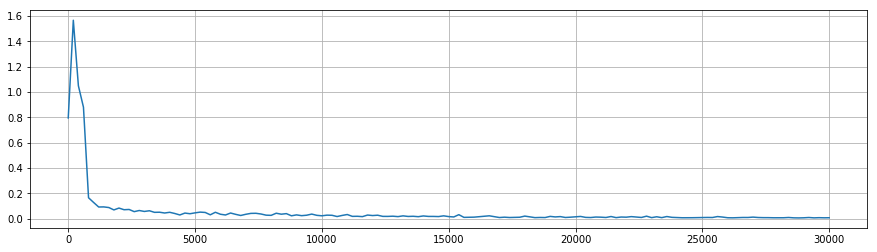

In [11]:
plt.figure().set_size_inches(15, 4)

x_axis  = [n * summary_frequency for n in range(0, len(losses))]
vx_axis = [n * summary_frequency * 4 for n in range(0, len(v_losses))]
# for data in [losses, v_losses]:
plt.plot(x_axis, losses)
plt.plot(vx_axis, v_losses)
plt.grid()

plt.show()

## 4. Having fun

Let us now see the world with neural network's eyes.

First recollect what the model has learned:

In [12]:
def evaluate(articles, session):
  for article in articles:
    session.run(reset_sample_state)
    predicted = []
    for word in article:
      prediction = session.run(sample_prediction, { sample_input: [dictionary[word]] })
      predicted.append(prediction[0])

    print_md(represent(article, predicted))

Let's ask to evaluate some provoking statements:

In [37]:
with tf.Session(graph=graph) as session:
  saver.restore(session, STORAGE_PATH)

  articles = [['британск', 'совет', 'взорва', 'аэропорт', 'UNK', 'вечер', 'посл', 'испуг', 'вокруг'],
              ['британск', 'бомб', 'взорва', 'аэропорт', 'UNK', 'вечер', 'посл', 'испуг', 'вокруг'],
              ['бомб', 'взорва', 'аэропорт', 'UNK', 'вечер', 'посл', 'испуг', 'вокруг'],
              ['секс', 'бомб', 'взорва', 'аэропорт', 'UNK', 'вечер', 'посл', 'танц'],
              ['британск', 'секс', 'бомб', 'взорва', 'аэропорт', 'UNK', 'вечер', 'посл', 'испуг', 'вокруг']]

  evaluate(articles, session)

INFO:tensorflow:Restoring parameters from ./storage/model


<span style='color: rgb(28.0, 227.0, 0)'>=></span> <span style='color: rgb(3.0, 252.0, 0)'>британск</span> <span style='color: rgb(2.0, 253.0, 0)'>совет</span> <span style='color: rgb(27.0, 228.0, 0)'>взорва</span> ... <span style='color: rgb(32.0, 223.0, 0)'>посл</span> <span style='color: rgb(22.0, 233.0, 0)'>испуг</span> <span style='color: rgb(28.0, 227.0, 0)'>вокруг</span>

<span style='color: rgb(181.0, 74.0, 0)'>=></span> <span style='color: rgb(3.0, 252.0, 0)'>британск</span> <span style='color: rgb(37.0, 218.0, 0)'>бомб</span> <span style='color: rgb(87.0, 168.0, 0)'>взорва</span> <span style='color: rgb(99.0, 156.0, 0)'>аэропорт</span> <span style='color: rgb(112.0, 143.0, 0)'>UNK</span> <span style='color: rgb(130.0, 125.0, 0)'>вечер</span> <span style='color: rgb(157.0, 98.0, 0)'>посл</span> <span style='color: rgb(135.0, 120.0, 0)'>испуг</span> <span style='color: rgb(181.0, 74.0, 0)'>вокруг</span>

<span style='color: rgb(181.0, 74.0, 0)'>=></span> <span style='color: rgb(41.0, 214.0, 0)'>бомб</span> <span style='color: rgb(84.0, 171.0, 0)'>взорва</span> <span style='color: rgb(100.0, 155.0, 0)'>аэропорт</span> <span style='color: rgb(114.0, 141.0, 0)'>UNK</span> <span style='color: rgb(135.0, 120.0, 0)'>вечер</span> <span style='color: rgb(157.0, 98.0, 0)'>посл</span> <span style='color: rgb(137.0, 118.0, 0)'>испуг</span> <span style='color: rgb(181.0, 74.0, 0)'>вокруг</span>

<span style='color: rgb(104.0, 151.0, 0)'>=></span> <span style='color: rgb(3.0, 252.0, 0)'>секс</span> <span style='color: rgb(10.0, 245.0, 0)'>бомб</span> <span style='color: rgb(64.0, 191.0, 0)'>взорва</span> <span style='color: rgb(80.0, 175.0, 0)'>аэропорт</span> <span style='color: rgb(90.0, 165.0, 0)'>UNK</span> <span style='color: rgb(100.0, 155.0, 0)'>вечер</span> <span style='color: rgb(126.0, 129.0, 0)'>посл</span> <span style='color: rgb(104.0, 151.0, 0)'>танц</span>

<span style='color: rgb(113.0, 142.0, 0)'>=></span> <span style='color: rgb(3.0, 252.0, 0)'>британск</span> <span style='color: rgb(1.0, 254.0, 0)'>секс</span> <span style='color: rgb(4.0, 251.0, 0)'>бомб</span> ... <span style='color: rgb(66.0, 189.0, 0)'>вечер</span> <span style='color: rgb(91.0, 164.0, 0)'>посл</span> <span style='color: rgb(70.0, 185.0, 0)'>испуг</span> <span style='color: rgb(113.0, 142.0, 0)'>вокруг</span>

As you can see, the results are quite impressive. The model does recognize the words by their context. Neural network here is at its best.

Moreover, prepending a statement with strongly provoking word `'неизвестный'` does not move the model off to a downward spiral of misunderstanding :)

In [43]:
with tf.Session(graph=graph) as session:
  saver.restore(session, STORAGE_PATH)

  articles = [['неизвестн', 'секс', 'бомб', 'раздел', 'в', 'аэропорт', 'UNK', '.', 'все', 'снима', 'вокруг'],
              ['неизвестн', 'бомб', 'раздел', 'в', 'аэропорт', 'UNK', '.', 'все', 'снима', 'вокруг'],
              ['неизвестн', 'секс', 'бомб', 'раздел', 'в', 'аэропорт'],
              ['неизвестн', 'секс', 'бомб', 'раздел', 'полност', 'в', 'аэропорт', 'для', 'фотосесс', 'вокруг'],
              ['неизвестн', 'сообщ', 'о', 'бомб', 'в', 'аэропорт', 'UNK', '.', 'все', 'испуга', 'вокруг'],
              ['неизвестн', 'сообщ', 'о', 'секс', 'бомб', 'в', 'аэропорт', 'UNK', '.', 'все', 'испуга', 'вокруг']]

  evaluate(articles, session)

INFO:tensorflow:Restoring parameters from ./storage/model


<span style='color: rgb(120.0, 135.0, 0)'>=></span> <span style='color: rgb(11.0, 244.0, 0)'>неизвестн</span> <span style='color: rgb(9.0, 246.0, 0)'>секс</span> <span style='color: rgb(59.0, 196.0, 0)'>бомб</span> ... <span style='color: rgb(51.0, 204.0, 0)'>в</span> <span style='color: rgb(77.0, 178.0, 0)'>аэропорт</span> <span style='color: rgb(83.0, 172.0, 0)'>UNK</span> <span style='color: rgb(111.0, 144.0, 0)'>.</span> <span style='color: rgb(85.0, 170.0, 0)'>все</span> <span style='color: rgb(97.0, 158.0, 0)'>снима</span> <span style='color: rgb(120.0, 135.0, 0)'>вокруг</span>

<span style='color: rgb(140.0, 115.0, 0)'>=></span> <span style='color: rgb(11.0, 244.0, 0)'>неизвестн</span> <span style='color: rgb(69.0, 186.0, 0)'>бомб</span> <span style='color: rgb(54.0, 201.0, 0)'>раздел</span> <span style='color: rgb(69.0, 186.0, 0)'>в</span> <span style='color: rgb(91.0, 164.0, 0)'>аэропорт</span> <span style='color: rgb(100.0, 155.0, 0)'>UNK</span> <span style='color: rgb(127.0, 128.0, 0)'>.</span> <span style='color: rgb(104.0, 151.0, 0)'>все</span> <span style='color: rgb(119.0, 136.0, 0)'>снима</span> <span style='color: rgb(140.0, 115.0, 0)'>вокруг</span>

<span style='color: rgb(77.0, 178.0, 0)'>=></span> <span style='color: rgb(11.0, 244.0, 0)'>неизвестн</span> <span style='color: rgb(9.0, 246.0, 0)'>секс</span> <span style='color: rgb(59.0, 196.0, 0)'>бомб</span> <span style='color: rgb(40.0, 215.0, 0)'>раздел</span> <span style='color: rgb(51.0, 204.0, 0)'>в</span> <span style='color: rgb(77.0, 178.0, 0)'>аэропорт</span>

<span style='color: rgb(41.0, 214.0, 0)'>=></span> <span style='color: rgb(11.0, 244.0, 0)'>неизвестн</span> <span style='color: rgb(9.0, 246.0, 0)'>секс</span> <span style='color: rgb(59.0, 196.0, 0)'>бомб</span> ... <span style='color: rgb(38.0, 217.0, 0)'>для</span> <span style='color: rgb(43.0, 212.0, 0)'>фотосесс</span> <span style='color: rgb(41.0, 214.0, 0)'>вокруг</span>

<span style='color: rgb(203.0, 52.0, 0)'>=></span> <span style='color: rgb(11.0, 244.0, 0)'>неизвестн</span> <span style='color: rgb(29.0, 226.0, 0)'>сообщ</span> <span style='color: rgb(43.0, 212.0, 0)'>о</span> <span style='color: rgb(153.0, 102.0, 0)'>бомб</span> <span style='color: rgb(146.0, 109.0, 0)'>в</span> <span style='color: rgb(147.0, 108.0, 0)'>аэропорт</span> <span style='color: rgb(169.0, 86.0, 0)'>UNK</span> <span style='color: rgb(189.0, 66.0, 0)'>.</span> <span style='color: rgb(183.0, 72.0, 0)'>все</span> <span style='color: rgb(189.0, 66.0, 0)'>испуга</span> <span style='color: rgb(203.0, 52.0, 0)'>вокруг</span>

<span style='color: rgb(203.0, 52.0, 0)'>=></span> <span style='color: rgb(11.0, 244.0, 0)'>неизвестн</span> <span style='color: rgb(29.0, 226.0, 0)'>сообщ</span> <span style='color: rgb(43.0, 212.0, 0)'>о</span> <span style='color: rgb(66.0, 189.0, 0)'>секс</span> <span style='color: rgb(162.0, 93.0, 0)'>бомб</span> <span style='color: rgb(151.0, 104.0, 0)'>в</span> <span style='color: rgb(156.0, 99.0, 0)'>аэропорт</span> <span style='color: rgb(175.0, 80.0, 0)'>UNK</span> <span style='color: rgb(192.0, 63.0, 0)'>.</span> <span style='color: rgb(186.0, 69.0, 0)'>все</span> <span style='color: rgb(189.0, 66.0, 0)'>испуга</span> <span style='color: rgb(203.0, 52.0, 0)'>вокруг</span>

However, having someone notified of a sex-bomb in an airport is still considered a bad news. On the other hand - given the source of our _bad_ news - perhaps that is what we had taught our model to.